# INVENTORY DATA ANALYSIS

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

c:\Users\Akshaya\OneDrive\Desktop\Xcelerate\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

df = pd.read_csv("inventory_data.csv")
df['sales_date'] = pd.to_datetime(df['sales_date'])
df = df.sort_values('sales_date')

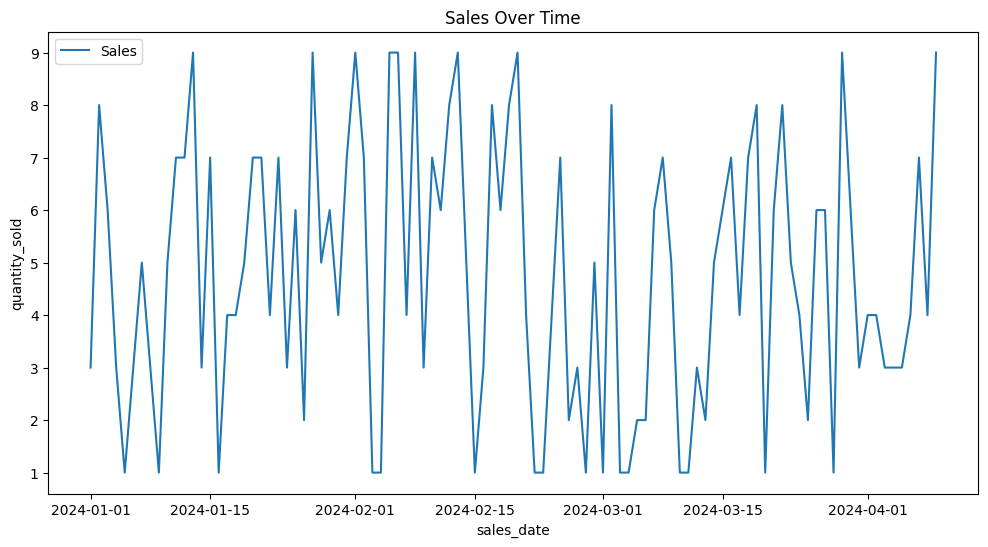

In [ ]:

plt.figure(figsize=(12, 6))
sns.lineplot(x='sales_date', y='quantity_sold', data=df, label='Sales')
plt.title("Sales Over Time")
plt.legend()
plt.show()

In [15]:
sales_series = df.set_index('sales_date')['quantity_sold']
model = ARIMA(sales_series, order=(5,1,0))
model_fit = model.fit()
pred = model_fit.forecast(steps=10)
print("ARIMA Forecast:", pred)

ARIMA Forecast: 2024-04-10    5.046624
2024-04-11    5.297797
2024-04-12    5.131265
2024-04-13    6.014876
2024-04-14    5.803544
2024-04-15    6.289929
2024-04-16    5.575202
2024-04-17    5.618138
2024-04-18    5.621311
2024-04-19    5.850767
Freq: D, Name: predicted_mean, dtype: float64


c:\Users\Akshaya\OneDrive\Desktop\Xcelerate\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Akshaya\OneDrive\Desktop\Xcelerate\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Akshaya\OneDrive\Desktop\Xcelerate\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


## ARIMA MODEL

                               SARIMAX Results                                
Dep. Variable:         stock_quantity   No. Observations:                  100
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -258.881
Date:                Sun, 23 Mar 2025   AIC                            529.762
Time:                        08:37:49   BIC                            545.333
Sample:                             0   HQIC                           536.062
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9296      0.112     -8.299      0.000      -1.149      -0.710
ar.L2         -0.7249      0.140     -5.161      0.000      -1.000      -0.450
ar.L3         -0.5959      0.138     -4.308      0.0

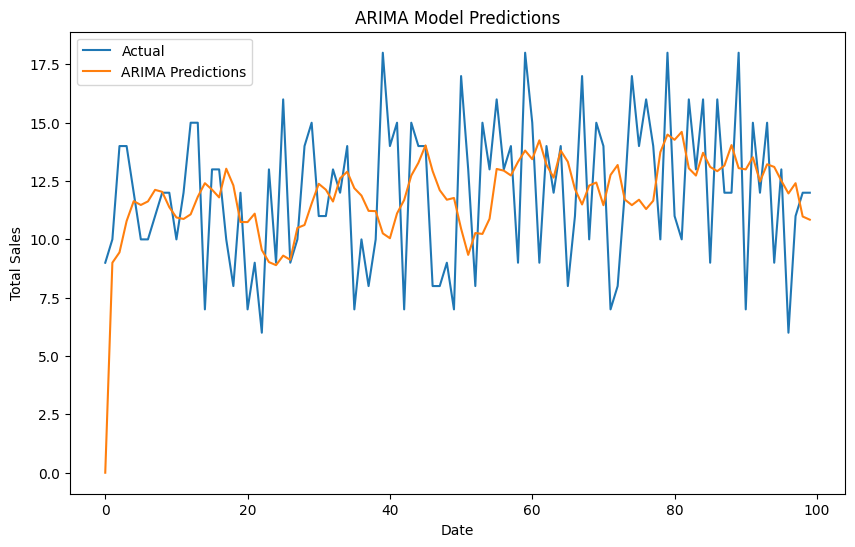

In [ ]:
model = ARIMA(df['stock_quantity'], order=(5, 1, 0))
model_fit = model.fit()
print(model_fit.summary())


plt.figure(figsize=(10, 6))
plt.plot(df.index, df['stock_quantity'], label='Actual')
plt.plot(df.index, model_fit.predict(start=0, end=len(df)-1, typ='levels'), label='ARIMA Predictions')
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

## GRU MODEL

c:\Users\Akshaya\OneDrive\Desktop\Xcelerate\.venv\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.0063
Epoch [20/100], Loss: 0.0050
Epoch [30/100], Loss: 0.0061
Epoch [40/100], Loss: 0.0062
Epoch [50/100], Loss: 0.0048
Epoch [60/100], Loss: 0.0051
Epoch [70/100], Loss: 0.0045
Epoch [80/100], Loss: 0.0043
Epoch [90/100], Loss: 0.0064
Epoch [100/100], Loss: 0.0070


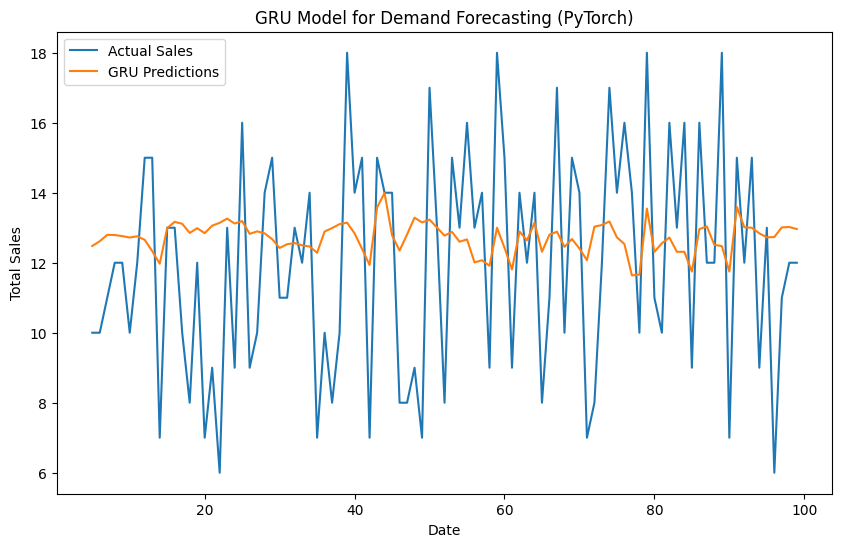

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

def create_dataset(data, look_back=3):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['stock_quantity']].values)


look_back = 5
X, Y = create_dataset(scaled_data, look_back)


X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  
Y = torch.tensor(Y, dtype=torch.float32)


dataset = TensorDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)


class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  
        return out


input_size = 1  
hidden_size = 50
output_size = 1
model = GRUModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


num_epochs = 100
for epoch in range(num_epochs):
    for batch_X, batch_Y in dataloader:
       
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


model.eval()
with torch.no_grad():
    train_predict = model(X).numpy()


train_predict = scaler.inverse_transform(train_predict)
Y = scaler.inverse_transform(Y.numpy().reshape(-1, 1))


plt.figure(figsize=(10, 6))
plt.plot(df.index[look_back:], Y, label='Actual Sales')
plt.plot(df.index[look_back:], train_predict, label='GRU Predictions')
plt.title('GRU Model for Demand Forecasting (PyTorch)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

## PROPHET MODEL

10:03:10 - cmdstanpy - INFO - Chain [1] start processing
10:03:10 - cmdstanpy - INFO - Chain [1] done processing


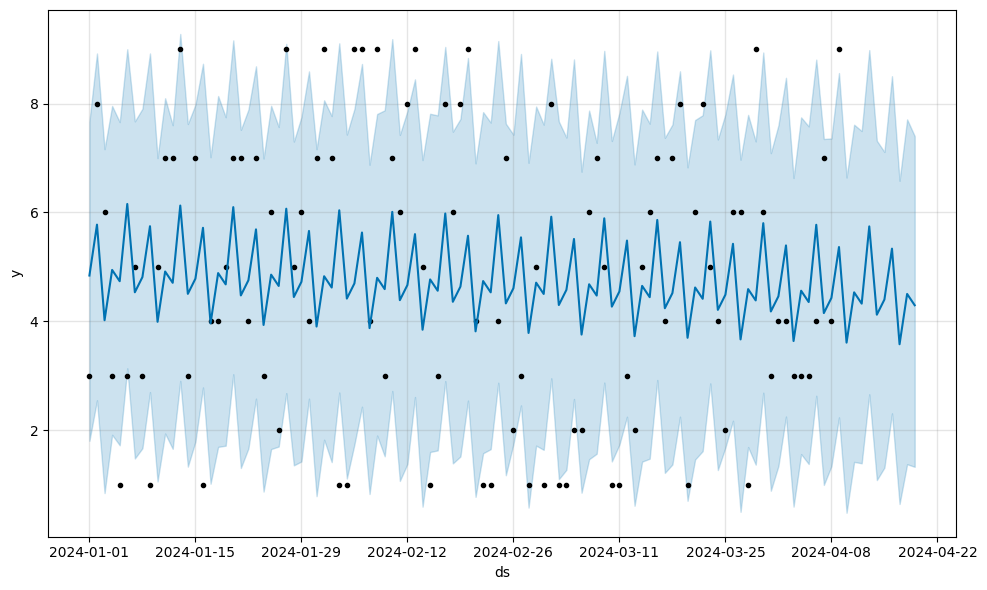

In [17]:
df_prophet = df[['sales_date', 'quantity_sold']].rename(columns={'sales_date': 'ds', 'quantity_sold': 'y'})
m = Prophet()
m.fit(df_prophet)
future = m.make_future_dataframe(periods=10)
forecast = m.predict(future)
fig = m.plot(forecast)
plt.show()

In [ ]:

scaler = MinMaxScaler()
df['scaled_sales'] = scaler.fit_transform(df[['quantity_sold']])
X = []
y = []
seq_length = 5

for i in range(len(df) - seq_length):
    X.append(df['scaled_sales'].iloc[i:i+seq_length].values)
    y.append(df['scaled_sales'].iloc[i+seq_length])

X, y = np.array(X), np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_test = torch.Tensor(X_train).unsqueeze(-1), torch.Tensor(X_test).unsqueeze(-1)
y_train, y_test = torch.Tensor(y_train), torch.Tensor(y_test)

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        _, h = self.gru(x)
        return self.fc(h[-1])

gru_model = GRUModel(input_size=1, hidden_size=64, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.01)


for epoch in range(100):
    optimizer.zero_grad()
    output = gru_model(X_train)
    loss = criterion(output, y_train.unsqueeze(-1))
    loss.backward()
    optimizer.step()


X_test_sample = X_test[:1]
gru_forecast = gru_model(X_test_sample).detach().numpy()
gr_forecast = scaler.inverse_transform(gru_forecast.reshape(-1, 1))
print("GRU Forecast:", gru_forecast)

GRU Forecast: [[0.23513299]]


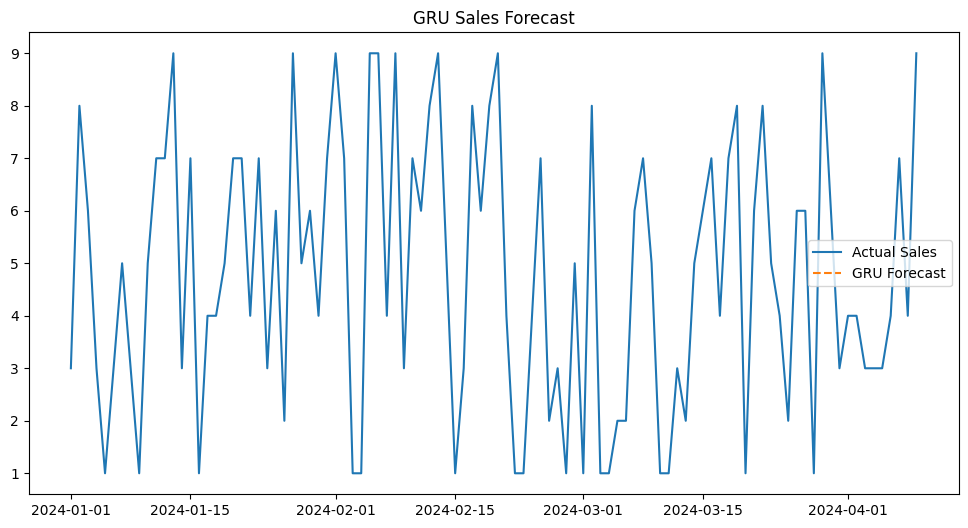

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(sales_series, label='Actual Sales')
plt.plot(pd.date_range(sales_series.index[-1], periods=len(gr_forecast), freq='D'), gr_forecast, label='GRU Forecast', linestyle='dashed')
plt.legend()
plt.title("GRU Sales Forecast")
plt.show()